# 作業 : (Kaggle)房價預測

# [作業目標]
- 試著模仿範例寫法, 在房價預測中, 觀察去除離群值的影響

# [作業重點]
- 觀察將極端值以上下限值取代, 對於分布與迴歸分數的影響 (In[5], Out[5])
- 觀察將極端值資料直接刪除, 對於分布與迴歸分數的影響 (In[6], Out[6])

In [1]:
# 做完特徵工程前的所有準備 (與前範例相同)
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

data_path = 'data/'
df_train = pd.read_csv(data_path + 'house_train.csv.gz')

train_Y = np.log1p(df_train['SalePrice'])
#log1p 對偏度比較大的數據用og1p函數進行轉化，使其更加服從高斯分佈(平滑數據)，此步處理可能會使我們後續的分類結果得到一個好的結果。
#log1p 像是一個數據壓縮到了一個區間，與數據的標準類似。 用expm1還原
df = df_train.drop(['Id', 'SalePrice'] , axis=1) #axis=1 column #axis=0 row
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [2]:
#只取 int64, float64 兩種數值型欄位, 存於 num_features 中
num_features = []
for dtype, feature in zip(df.dtypes, df.columns): #zip & for 將兩個 list 以迴圈的方式一次各取一個元素出來處理
    if dtype == 'float64' or dtype == 'int64':
        num_features.append(feature)
print(f'{len(num_features)} Numeric Features : {num_features}\n')

36 Numeric Features : ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']



In [3]:
# 削減文字型欄位, 只剩數值型欄位
df = df[num_features]
df = df.fillna(-1) #使用指定的方法填充NA / NaN值。
MMEncoder = MinMaxScaler()
# MinMaxScaler() 將屬性縮放到一個指定的最大和最小值（通常是1-0）之間
# 目的包括： 1、對於方差非常小的屬性可以增強其穩定性。 2、維持稀疏矩陣中為0的條目。
train_num = train_Y.shape[0]
df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,548,0,61,0,0,0,0,0,2,2008
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,460,298,0,0,0,0,0,0,5,2007
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,608,0,42,0,0,0,0,0,9,2008
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,642,0,35,272,0,0,0,0,2,2006
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,836,192,84,0,0,0,0,0,12,2008


# 作業1
* 試著限制 '1樓地板面積(平方英尺)' (1stFlrSF) 欄位的上下限, 看看能否再進一步提高分數?

In [4]:
# 顯示 1stFlrSF 與目標值的散佈圖
import seaborn as sns
import matplotlib.pyplot as plt
sns.regplot(x = df['1stFlrSF'][:train_num], y=train_Y) #regplot 繪製線性回歸模型圖
plt.show()

# 做線性迴歸, 觀察分數
train_X = MMEncoder.fit_transform(df) #先擬合數據，然後轉化它將其轉化為標準形式
estimator = LinearRegression()
cross_val_score(estimator, train_X, train_Y, cv=5).mean() #cross_val_score() 通過交叉驗證評估分數
# estimator 實現“ fit”的估計器對象 用於擬合數據的對象。
# X ： 類似數組要擬合的數據。例如可以是列表或數組。
# y ： 類似數組，可選，默認值：無  在監督學習的情況下要嘗試預測的目標變量。
#cv ： int，交叉驗證生成器或可迭代的  無，要使用默認的三折交叉驗證  整數，用於指定的折疊次數(Stratified)KFold，

<Figure size 640x480 with 1 Axes>

0.8452059048224578

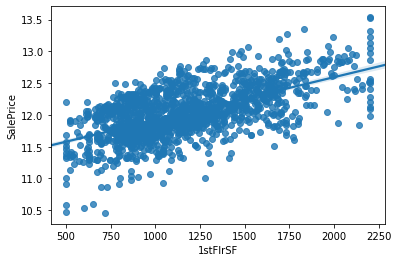

0.8822361961094201

In [5]:
# 將 1stFlrSF 限制在你覺得適合的範圍內, 調整離群值
"""
Your Code Here
"""
df['1stFlrSF'] = df['1stFlrSF'].clip(500, 2200) #clip將數組中的元素限制在a_min, a_max之間，>a_max使它=a_max，<a_min使它=a_min
sns.regplot(x = df['1stFlrSF'], y=train_Y)
plt.show() 

# 做線性迴歸, 觀察分數
train_X = MMEncoder.fit_transform(df)
estimator = LinearRegression()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

# 作業2
* 續前題, 去除離群值有兩類方式 :  捨棄離群值(刪除離群的資料) 以及調整離群值,  
請試著用同樣的上下限, 改為 '捨棄離群值' 的方法, 看看結果會變好還是變差? 並試著解釋原因。

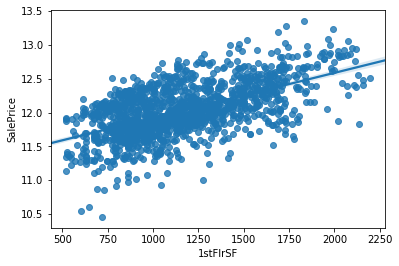

0.8894142262595756

In [6]:
# 將 1stFlrSF 限制在你覺得適合的範圍內, 捨棄離群值
"""
Your Code Here
"""
keep_indexs = (df['1stFlrSF']> 500) & (df['1stFlrSF']< 2200)
df = df[keep_indexs]
train_Y = train_Y[keep_indexs]
sns.regplot(x = df['1stFlrSF'], y=train_Y)
plt.show()

# 做線性迴歸, 觀察分數
train_X = MMEncoder.fit_transform(df)
estimator = LinearRegression()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

請試著用同樣的上下限, 改為 '捨棄離群值' 的方法, 看看結果會變好還是變差? 並試著解釋原因。

結果變好
調整離群值：迴歸模型中有些點靠近邊界，離群值仍影響到數據做交叉驗證
捨棄離群值：迴歸模型較集中，對交叉驗證影響較小